In [107]:
# Import Modules 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import constants as const # import astropy constants
import astropy.units as u

from ReadFile import Read
from CenterOfMass import CenterOfMass
from astropy.constants import G

G = G.to(u.kpc*u.km**2/u.s**2/u.Msun)
#Converting G to necessary units

In [108]:

class MassProfile:
#Class to calculate a mass profiles.
    def __init__(self, galaxy, snap):
        '''
        Input
        galaxy: 'str', string with Galaxy Name
        snap: 'int', snapshot number
        '''
        #adding string of filenumber to the value '000'
        ilbl = '000' + str(snap)
        #removing all but last 3 digits
        ilbl = ilbl[-3:]
        self.filename = '%s_'%(galaxy) + ilbl + '.txt'
        #thus, only need to input 'MW' or whatever and then '10' for
        #snapnumber 10
        
        # read data in the given file using Read
        self.time, self.total, self.data = Read(self.filename)

        # store the mass, positions, velocities of only the particles of the given type
        #Don't need this actually bc don't care about type?
        self.m = self.data['m']
        #Reading in mass 
        self.x = self.data['x']*u.kpc #x position
        self.y = self.data['y']*u.kpc #y position
        self.z = self.data['z']*u.kpc #z position
        #Reading in position coordinates

        self.gname = galaxy
        #Storing name of galaxy as a global property

    def MassEnclosed(self, ptype, rad):
        '''
        Creating index & determining total mass
        Need ptype when defining index, b/c it's not an argument of __init__(), need
            to extract from self.data
        Input:   ptype -> int, 1-3 corresponding to object type
                 rad -> array of radiuses
        Outputs: mass_encl -> array, total mass enclosed (Msun)
        
        compute the mass enclosed within a given radius of the COM 
        position for a specified galaxy and a specified component of that galaxy.
        '''
        
        #Following procedure from HW 4 for calling CenterOfMass function to find position, 
        COM = CenterOfMass(self.filename, 2)
        #Using ptype = 2 because we're using disk particles to calculate COM position
        COM_p = COM.COM_P(.1)
        #Defining COM position
        
        self.index = np.where(self.data['type'] == ptype)
        #create an array to store indexes of particles of desired ptype 
        
        #ptype matters now, so we use index
        # change reference frame to COM frame, 
        # compute the difference between particle coordinates 
        m_p = self.m[self.index]
        x_p = self.x[self.index] - COM_p[0] #x component
        y_p = self.y[self.index] - COM_p[1] #y component
        z_p = self.z[self.index] - COM_p[2] #z component
        r_p = np.sqrt(x_p**2 + y_p**2 + z_p**2)
        #Using distance formula to get magnitude of position vector

        mass_array = np.zeros_like(rad)
        #Initializing array with same dimensions as rad input

        for i, r_el in enumerate(rad):
        #looping over radius array (rad), where r_el is an element in the array
            index_rad = np.where(r_el*u.kpc > r_p)
            #Determining where our r_p is enclosed w/in the array
            mass_encl = np.sum(m_p[index_rad])
            mass_array[i] = mass_encl

        return mass_encl*1e10*u.Msun

    def MassEnclosedTotal(self, rad):
        '''
        Input:  rad -> 1D array of radii
        Output: Total_Mass -> array of masses, total enclosed mass at each radius
                of input array 
        '''
        if self.gname == 'M33':
        #Writing if statement to account for M33, which doesn't have a bulge
            HMass = self.MassEnclosed(1, rad) #halo mass
            DMass = self.MassEnclosed(2, rad) #disk mass
            Total_Mass = HMass + DMass
            
        else:
        #Case for other galaxies, includes bulge mass
            HMass = self.MassEnclosed(1, rad) #halo mass
            DMass = self.MassEnclosed(2, rad) #disk mass
            BMass = self.MassEnclosed(3, rad) #bulge mass
            Total_Mass = HMass + DMass + BMass
            
        return Total_Mass*u.Msun
        #returning Total_Mass in units of Msun  

    def HernquistMass(self, spec_rad, a, Mhalo):
        '''
        Computes mass enclosed within a given radius.
        PARAMETERS
        Input:  spec_rad -> array, a specific radius of interest
                a -> int, scale factor
                Mhalo -> int, mass of halo
        Output: Mhalo -> int, in mass of Msun
        '''
        MHern = Mhalo*(spec_rad**2/(a + spec_rad)**2)
        return MHern*u.Msun

    def CircularVelocity(self, ptype, rad):
        '''
        Computes circular speed using the Mass enclosed at each radius, 
        assuming spherical symmetry.
        Input:  ptype -> int, 1-3 corresponding to type of object
                rad_array -> array of radius values
        Output: c_speeds -> array of circular speeds in km/s (rounded to 2 decimal places)
        '''
        mass_enclosed = self.MassEnclosed(ptype, rad)
        
        c_speeds = np.sqrt(G*mass_enclosed/rad*u.kpc)
        
        return np.round(c_speeds, 2)
        
    def CircularVelocityTotal(rad):
        '''
        Input:  rad -> array of radius values
        Output: c_speeds -> array of circular velocity in km/s, representing total Vcirc
                created by all galaxy components at each rad of input array
        *the total circular velocity is NOT just the circular velocity of each 
        individual galaxy component summed together.
        '''
        m_tot = self.MassEnclosedTotal(rad)
        c_speeds = np.sqrt(G*m_tot/rad*u.kpc)
        return c_speeds

    def HernquistVCirc(self, spec_rad, a, Mhalo):
        hernquist_mass = self.HernquistMass(spec_rad, a, Mhalo)
        HernVC = np.sqrt(G*hernquist_mass/spec_rad*u.kpc)
        return np.round(HernVC, 2)
        

In [109]:
#Initializing MassProfile class for our 3 galaxies
MW = MassProfile("MW", 0)
M31 = MassProfile("M31", 0)
M33 = MassProfile("M33", 0)
#Creating array of radii as input
rad = np.arange(.25, 30.5, 1.5)

ValueError: x and y must have same first dimension, but have shapes (21,) and (1,)

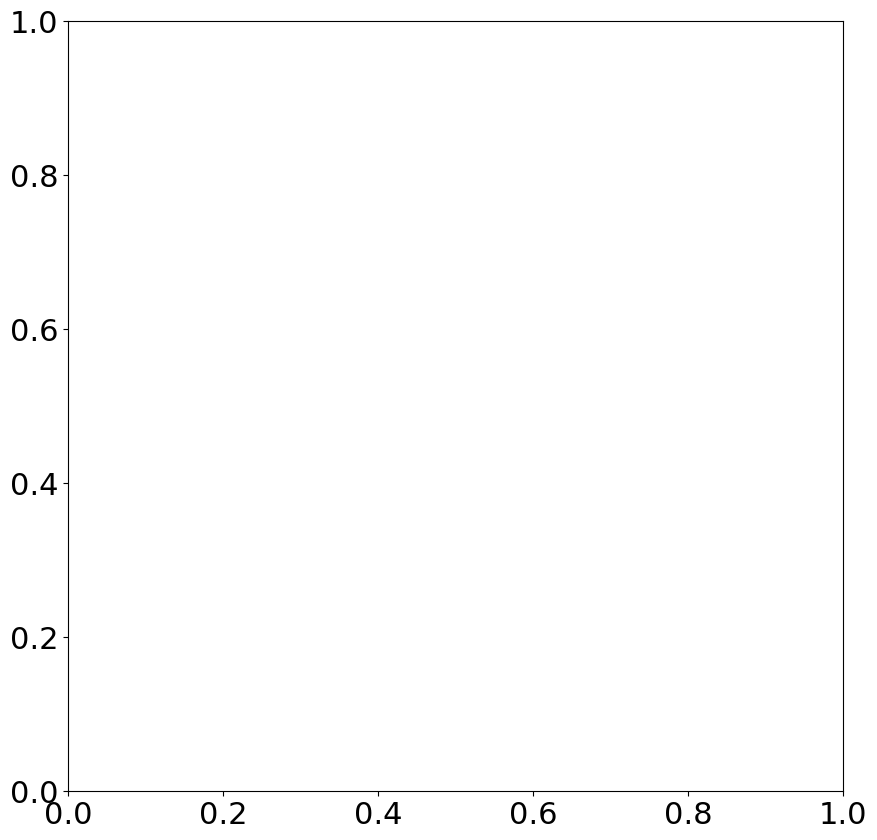

In [110]:
#Plotting each component of the MW mass enclosed profile
    #halo, disk, bulge, total, & Hernquist

#Getting enclosed halo masses at each element in rad
HMW = MW.MassEnclosed(1, rad)
DMW = MW.MassEnclosed(2, rad)
BMW = MW.MassEnclosed(3, rad)

totalmass = MW.MassEnclosedTotal(rad)

#Hernquist mass
Mhalo = 1.975e12
MHern = MW.HernquistMass(rad, 60, Mhalo)

#Plotting
fig = plt.figure(figsize=(10,10))  # sets the scale of the figure
ax = plt.subplot(111)

#Y axis
#plt.semilogy(rad, 
#ax.semilogy(rad, HMW(), color = 'blue', linewidth = 5, label = "Halo MW")

#plt.plot(rad, np.log10(HMW.to_value()), color='limegreen', linewidth=5, label='MW Halo')
plt.plot(rad, HMW, color='limegreen', linewidth=5, label='MW Halo')

# nothing is working :( don't have same dimension/shape and I don't know what to do about that


# Add labels
plt.xlabel('Radius (kpc)', fontsize=22)
plt.ylabel('log(mass) (Msun)', fontsize=22)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='upper right',fontsize='x-large')
#Saying where to place legend

# Save to a file
plt.savefig('MW_MassEncl.png')

In [ ]:
#Plotting for MW circular velocity mass

VHMW = MW.CircularVelocity(1, rad) #halo
VDMW = MW.CircularVelocity(2, rad) #disk
VBMW = MW.CircularVelocity(3, rad) #bulge
totalmass = MW.MassEnclosedTotal(rad)

#Hernquist mass
Mhalo = 1.975e12
MHern = M33.HernquistVCirc(rad, 30, Mhalo)

#Plotting
fig = plt.figure(figsize=(10,10))  # sets the scale of the figure
ax = plt.subplot(111)

plt.plot(rad, VHMW)

# Add labels
plt.xlabel('Radius (kpc)', fontsize=22)
plt.ylabel('Circular velocity (km/s)', fontsize=22)

#set axis limits
plt.xlim(-17,-26)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='upper right',fontsize='x-large')
#Saying where to place legend

# Save to a file
plt.savefig('MWRotCurve.png')

In [ ]:
#Plotting for M31 mass enclosed profile

HM31 = M31.MassEnclosed(1, rad) #halo
DM31 = M31.MassEnclosed(2, rad) #disk
BM31 = M31.MassEnclosed(3, rad) #bulge
totalmass = M31.MassEnclosedTotal(rad)

#Hernquist mass
Mhalo = 1.921e12
MHern = M31.HernquistMass(rad, 60, Mhalo)

#Plotting
fig = plt.figure(figsize=(10,10))  # sets the scale of the figure
ax = plt.subplot(111)

# Add labels
plt.xlabel('Radius (kpc)', fontsize=22)
plt.ylabel('log(mass) (Msun)', fontsize=22)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='upper right',fontsize='x-large')
#Saying where to place legend

# Save to a file
plt.savefig('M31_MassEncl.png')

In [ ]:
#Plotting for M31 circular velocity mass

VHM31 = M31.CircularVelocity(1, rad) #halo
VDM31 = M31.CircularVelocity(2, rad) #disk
VBM31 = M31.CircularVelocity(3, rad) #bulge
totalmass = M31.MassEnclosedTotal(rad)

#Hernquist mass
Mhalo = 1.921e12
MHern = M33.HernquistVCirc(rad, 30, Mhalo)

#Plotting
fig = plt.figure(figsize=(10,10))  # sets the scale of the figure
ax = plt.subplot(111)

# Add labels
plt.xlabel('Radius (kpc)', fontsize=22)
plt.ylabel('Circular velocity (km/s)', fontsize=22)

#set axis limits
plt.xlim(-17,-26)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='upper right',fontsize='x-large')
#Saying where to place legend

# Save to a file
plt.savefig('M31RotCurve.png')

In [ ]:
#Plotting for M33 mass enclosed profile

HM33 = M33.MassEnclosed(1, rad)
DM33 = M33.MassEnclosed(2, rad)
totalmass = M33.MassEnclosedTotal(rad)

#Hernquist mass
Mhalo = .187e12
MHern = M33.HernquistMass(rad, 30, Mhalo)

#Plotting
fig = plt.figure(figsize=(10,10))  # sets the scale of the figure
ax = plt.subplot(111)

# Add labels
plt.xlabel('Radius (kpc)', fontsize=22)
plt.ylabel('log(mass) (Msun)', fontsize=22)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='upper right',fontsize='x-large')
#Saying where to place legend

# Save to a file
plt.savefig('M33_MassEncl.png')


In [ ]:
#Plotting for M33 circular velocity mass

VHM33 = M33.CircularVelocity(1, rad) #halo
VDM33 = M33.CircularVelocity(2, rad) #disk
totalmass = M33.MassEnclosedTotal(rad)

#Hernquist mass
Mhalo = .187e12
MHern = M33.HernquistVCirc(rad, 30, Mhalo)

#Plotting
fig = plt.figure(figsize=(10,10))  # sets the scale of the figure
ax = plt.subplot(111)


# Add labels
plt.xlabel('Radius (kpc)', fontsize=22)
plt.ylabel('Circular velocity (km/s)', fontsize=22)

#set axis limits
plt.xlim(-17,-26)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='upper right',fontsize='x-large')
#Saying where to place legend

# Save to a file
plt.savefig('M33RotCurve.png')